In [14]:
import time
import subprocess
import matplotlib.pyplot as plt
import psutil
import os
import re
import threading
import csv
import signal
import numpy as np
import math
import fcntl
import select
import stat

In [2]:
models = ["context_generator","DT_generator_c","DT_generator","IDT_generator","subroutine_generator","IDT_generator_c","context_generator_c","subroutine_generator_c","repl_generator_c"]

In [3]:
for model in models:
    subprocess.run(["clang++", "-std=c++20", model+".cpp", "-o", model])


In [4]:
directory = './grammars'
files = os.listdir(directory)
files.remove("simple_grammar.json")
files.remove("recursive.json")
print(files)

['math.json', 'css.json', 'html.json', 'regular_expression.json']


In [5]:
depth = [8,16,32,64,128]

In [6]:
result = {}
timeout = 20  # Timeout for each test in seconds

def set_non_blocking(fd):
    flags = fcntl.fcntl(fd, fcntl.F_GETFL)
    fcntl.fcntl(fd, fcntl.F_SETFL, flags | os.O_NONBLOCK)

def ensure_executable(file_path):
    try:
        current_permissions = stat.S_IMODE(os.lstat(file_path).st_mode)
        os.chmod(file_path, current_permissions | stat.S_IXUSR | stat.S_IXGRP | stat.S_IXOTH)
    except OSError as e:
        print(f"Error setting executable permissions on {file_path}: {e}")

def safe_read(stream):
    try:
        chunk = stream.read(4096)
        return b'' if chunk is None else chunk
    except Exception:
        return b''

def compile_and_run(program_name, file_name, depth_value):
    print(f"Running: {program_name} with {file_name} at depth {depth_value}")
    filetype = ".c" if "_c" in program_name else ".fth"
    current_file_name = f"{program_name}_{depth_value}_{file_name}{filetype}"
    output_file = current_file_name[:-2] + ".out" if filetype == ".c" else current_file_name
    
    try:
        if filetype == ".c":
            subprocess.run(
                ["./"+program_name, "-p", f"./grammars/{file_name}", "-d", str(depth_value), "-o", current_file_name, "--endless"],
                check=True, timeout=timeout
            )
            subprocess.run(
                ["clang", current_file_name, "-o", output_file],
                check=True, timeout=140
            )
            ensure_executable(output_file)
            cmd = ["./" + output_file]
        else:
            subprocess.run(
                ["./"+program_name, "-p", f"./grammars/{file_name}", "-d", str(depth_value), "-o", current_file_name, "--endless"],
                check=True, timeout=timeout
            )
            cmd = ["gforth-fast", current_file_name, "-e", "bye"]

        process = subprocess.Popen(
            cmd,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            bufsize=0,
            universal_newlines=False,
            preexec_fn=os.setsid
        )

        set_non_blocking(process.stdout.fileno())
        set_non_blocking(process.stderr.fileno())

        start_time = time.time()
        total_bytes = 0

        while time.time() - start_time < timeout:
            ready, _, _ = select.select([process.stdout, process.stderr], [], [], 1)
            for stream in ready:
                chunk = safe_read(stream)
                total_bytes += len(chunk)

            if process.poll() is not None:
                break

        if process.poll() is None:
            os.killpg(os.getpgid(process.pid), signal.SIGTERM)
            try:
                process.wait(timeout=5)
            except subprocess.TimeoutExpired:
                os.killpg(os.getpgid(process.pid), signal.SIGKILL)

        elapsed_time = min(time.time() - start_time, timeout)
        output_speed = total_bytes / elapsed_time
        print(f"Finished: {program_name} {file_name} {depth_value} - {output_speed:.2f} Bytes/s")
        return output_speed

    except subprocess.CalledProcessError:
        print(f"Error: {program_name} {file_name} {depth_value} - Compilation or execution failed")
        return 0
    except subprocess.TimeoutExpired:
        print(f"Timeout: {program_name} {file_name} {depth_value} - Execution timed out")
        return 0
    except Exception as e:
        print(f"Unexpected error: {program_name} {file_name} {depth_value} - {e}")
        return 0

# Main execution loop
for program_name in models:
    result[program_name] = {}
    for file_name in files:
        result[program_name][file_name] = {}
        for depth_value in depth:
            if "math" in file_name and depth_value > 64:
                continue
            output_speed = compile_and_run(program_name, file_name, depth_value)
            result[program_name][file_name][depth_value] = output_speed

print("Final results:", result)

Running: context_generator with math.json at depth 8
Code written to file successfully.
Finished: context_generator math.json 8 - 6393241.60 Bytes/s
Running: context_generator with math.json at depth 16
Code written to file successfully.
Finished: context_generator math.json 16 - 5809152.00 Bytes/s
Running: context_generator with math.json at depth 32
Code written to file successfully.
Finished: context_generator math.json 32 - 5643673.60 Bytes/s
Running: context_generator with math.json at depth 64
Code written to file successfully.
Finished: context_generator math.json 64 - 5622374.40 Bytes/s
Running: context_generator with css.json at depth 8
Code written to file successfully.
Finished: context_generator css.json 8 - 13223731.20 Bytes/s
Running: context_generator with css.json at depth 16
Code written to file successfully.
Finished: context_generator css.json 16 - 7035494.40 Bytes/s
Running: context_generator with css.json at depth 32
Code written to file successfully.
Finished: con

In [7]:
## convert the result in MB/s
for i in range(len(models)):
    program_name = models[i]
    for j in range(len(files)):
        file_name = files[j]
        for k in range(len(depth)):
            depth_value = depth[k]
            if program_name in result and file_name in result[program_name] and depth_value in result[program_name][file_name]:
                result[program_name][file_name][depth_value] = result[program_name][file_name][depth_value] / 1024 / 1024


In [8]:
# Save the result in a csv file
with open('results.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Program', 'File', 'Depth', 'Average Throughput Rate (MB/s)'])
    for program_name, files_dict in result.items():
        for file_name, depths_dict in files_dict.items():
            for depth_value, avg_throughput_rate in depths_dict.items():
                writer.writerow([program_name, file_name, depth_value, avg_throughput_rate])

print("Results have been written to results.csv")


Results have been written to results.csv


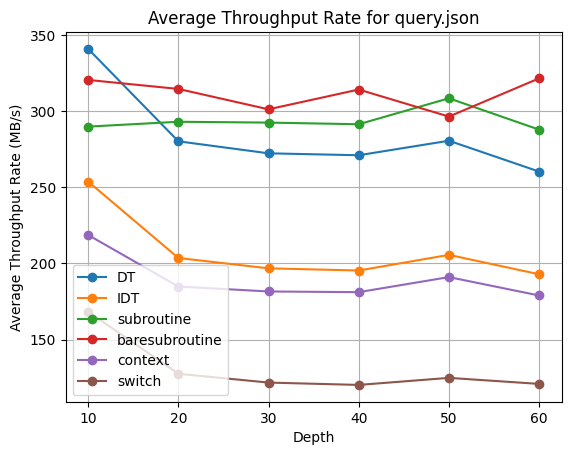

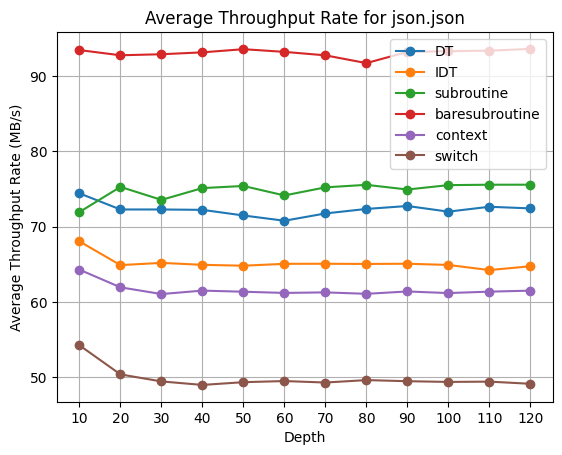

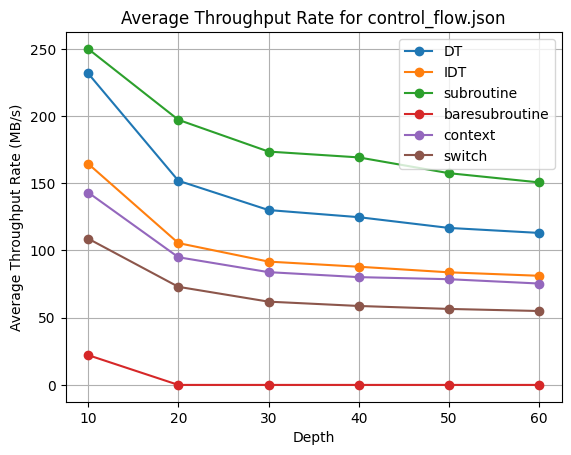

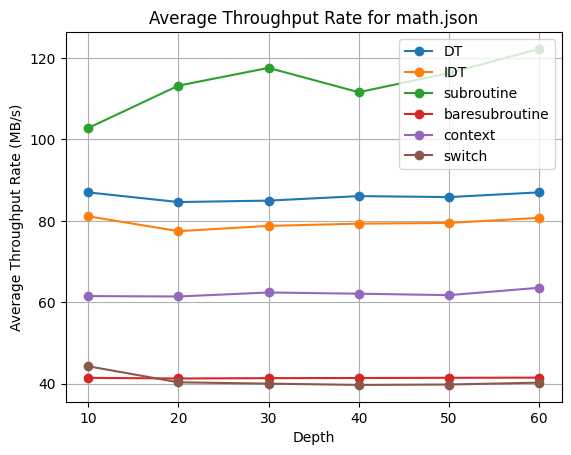

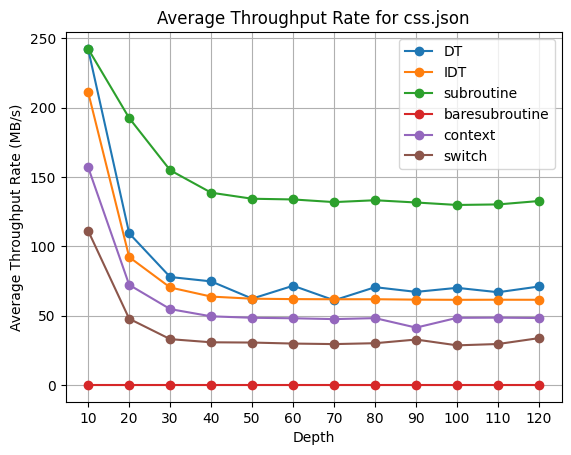

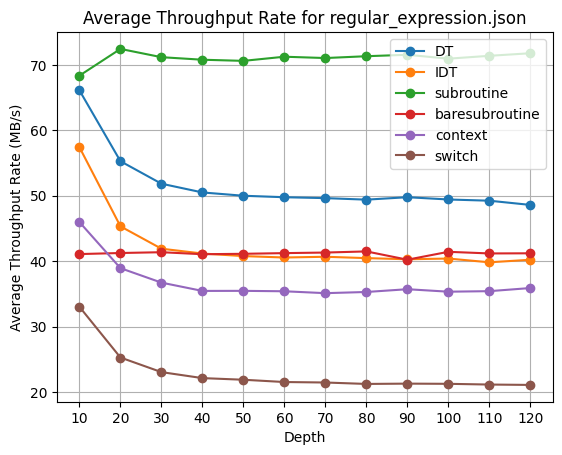

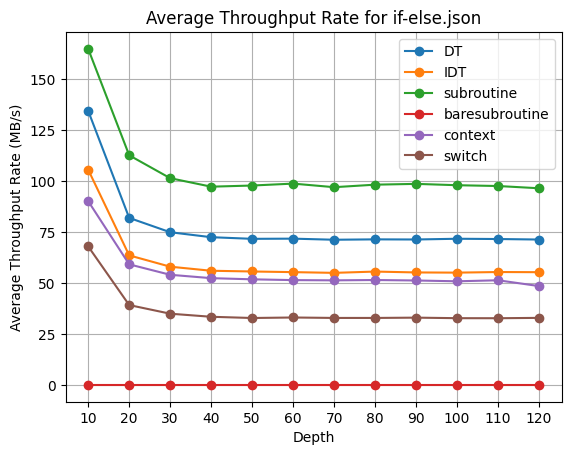

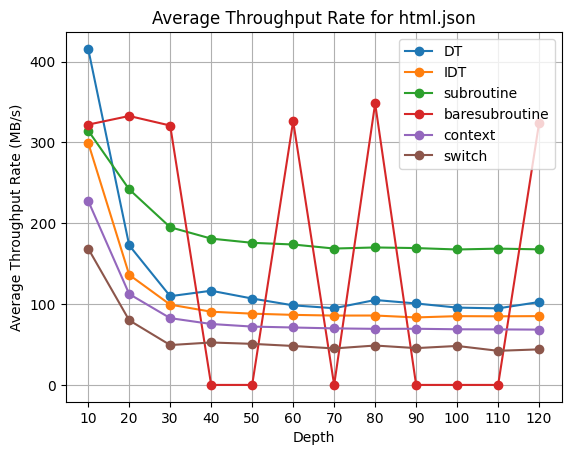

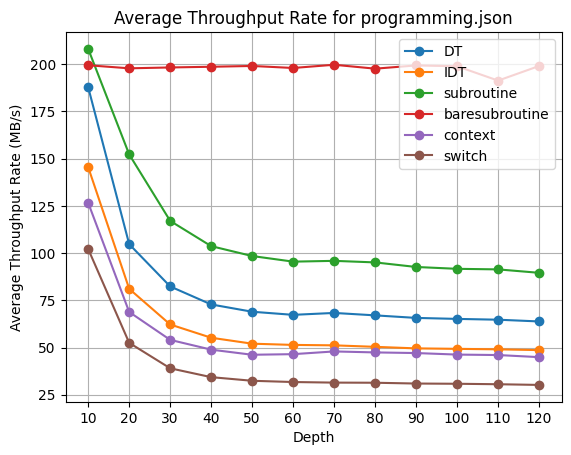

In [34]:
csv_filename = 'results2.csv'

results = {}

with open(csv_filename, mode='r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        program_name = row['Program']
        file_name = row['File']
        dp = int(row['Depth'])
        avg_throughput_rate = float(row['Average Throughput Rate (MB/s)'])

        if program_name not in results:
            results[program_name] = {}
        if file_name not in results[program_name]:
            results[program_name][file_name] = {}

        if dp not in results[program_name][file_name]:
            results[program_name][file_name][dp] = []
        
        results[program_name][file_name][dp].append(avg_throughput_rate)

for file_name in {file_name for program_data in results.values() for file_name in program_data.keys()}:
    plt.figure()
    for program_name in results.keys():
        if file_name in results[program_name]:
            depths = sorted(results[program_name][file_name].keys())
            rates = [results[program_name][file_name][d] for d in depths]
            plt.plot([x for x in depths], rates, marker='o', label=program_name)
    
    plt.xlabel('Depth')
    plt.ylabel('Average Throughput Rate (MB/s)')
    plt.title(f'Average Throughput Rate for {file_name}')
    plt.legend()
    plt.grid(True)

    plt.xticks(depths, [str(d) for d in depths])

    plt.savefig(f"./result/{file_name}_throughput.png")
    plt.show()

In [33]:

import glob

current_directory = os.getcwd()
files = glob.glob(os.path.join(current_directory, '*.fth'))
files += glob.glob(os.path.join(current_directory, '*.c'))
files += glob.glob(os.path.join(current_directory, '*.out'))
files += glob.glob(os.path.join(current_directory, '*.rs'))
for file in files:
    try:
        os.remove(file)
        print(f'Deleted: {file}')
    except Exception as e:
        print(f'Error deleting {file}: {e}')


Deleted: /Users/apple/gForthVM/subroutine_20_query.c
Deleted: /Users/apple/gForthVM/subroutine_100_if-else.c
Deleted: /Users/apple/gForthVM/subroutine_30_query.c
Deleted: /Users/apple/gForthVM/subroutine_70_html.c
Deleted: /Users/apple/gForthVM/subroutine_80_json.c
Deleted: /Users/apple/gForthVM/subroutine_50_if-else.c
Deleted: /Users/apple/gForthVM/subroutine_10_json.c
Deleted: /Users/apple/gForthVM/subroutine_40_regular_expression.c
Deleted: /Users/apple/gForthVM/subroutine_80_if-else.c
Deleted: /Users/apple/gForthVM/subroutine_30_control_flow.c
Deleted: /Users/apple/gForthVM/subroutine_40_control_flow.c
Deleted: /Users/apple/gForthVM/subroutine_20_css.c
Deleted: /Users/apple/gForthVM/subroutine_120_json.c
Deleted: /Users/apple/gForthVM/subroutine_60_html.c
Deleted: /Users/apple/gForthVM/subroutine_10_math.c
Deleted: /Users/apple/gForthVM/subroutine_90_json.c
Deleted: /Users/apple/gForthVM/subroutine_110_css.c
Deleted: /Users/apple/gForthVM/subroutine_60_regular_expression.c
Deleted: